# Ein Bezirk – ein Name

## Gemeinden mit dem höchsten Vorkommen einzelner Vornamen bei Lebendgeborenen

Das Ziel dieses Projekts ist es, die Gemeinden mit dem höchsten Vorkommen von einzelnen Vornamen bei Lebendgeborenen in Österreich zu identifizieren. Hierbei wird auch der höchste relative Anteil an gleich benannten Lebendgeborenen unter Berücksichtigung der Einwohnerzahl berechnet. Das Projekt wird von Raphael Koller und Lena Willisits durchgeführt.

### Datenquellen

Die geplanten Datenquellen für dieses Projekt sind:

- [Statistik Austria: Vornamen nach Geburtsjahr, Geschlecht und politischem Bezirk ab 2010](https://www.data.gv.at/katalog/de/dataset/stat_vornamen#resources)
- [Statistik Austria: Bevölkerung seit 1869 für Gemeinden, Politische Bezirke und Bundesland](https://www.data.gv.at/katalog/de/dataset/stat_bevolkerung-seit-1869-fur-politische-bezirke-und-bundesland)

### Data Storage

Als Datenbank für dieses Projekt wird Elasticsearch verwendet.

### Geplanter Ablauf

1. Ein Jupyter Notebook für das Projekt anlegen.
2. Infrastruktur-Aspekte des Projekts planen.
3. Docker-Container einrichten, um Elasticsearch DB zu starten (mittels `docker-compose.yml`).
4. Index in Elasticsearch anlegen.
5. Verbindung zur Datenbank über DataGrip aufbauen.
6. Tabellen in DataGrip mit CSV-Inhalten befüllen.
7. Abfragen formulieren, um das Projektthema zu erarbeiten.
8. Kibana für die Suche und Visualisierung nutzen.
9. Explorative Daten-Erkundung mittels Pandas durchführen.
10. Markdown-Notizen hinzufügen, um das Projekt zu beschreiben.
11. Das Projekt finalisieren.
12. Das Notebook testen (vom Anfang bis zum Ende ausführen).
13. Überprüfen, ob alle Kriterien laut Projektspezifikation erfüllt sind.

### Erwartetes Ergebnis

Das erwartete Ergebnis dieses Projekts ist ein gut strukturiertes Jupyter Notebook, das alle notwendigen Informationen enthält, um die Ergebnisse zu reproduzieren. Zudem sollen verschiedene Methoden der Big Data erkundet und Tools der Data Science angewendet werden. Schließlich soll eine spannende Geschichte mit Hilfe der aufbereiteten Daten erzählt werden.

### Python Pakete importieren bzw. ggf. installieren

In [16]:
try:
    from elasticsearch import Elasticsearch, helpers
except:
    !pip install elasticsearch
    from elasticsearch import Elasticsearch, helpers

### Zum Elasticsearch Node mittels Basic Authentication verbinden

In [11]:
es = Elasticsearch(
    "http://81.173.84.159:9200",
    basic_auth=("elastic", "iA7LwG44T2Dq5NXd9D7C")
)

In [147]:
try:
    print(es.info())
except:
    print("Wait until Elasticsearch is fully started")

{'name': '7f76c63ac5bd', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'CrGZljlSQ0CVFbvNI-SiZg', 'version': {'number': '8.7.1', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': 'f229ed3f893a515d590d0f39b05f68913e2d9b53', 'build_date': '2023-04-27T04:33:42.127815583Z', 'build_snapshot': False, 'lucene_version': '9.5.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'}


In [143]:
if es.ping():
    print("Connected to Elasticsearch")
else:
    print("Could not connect to Elasticsearch")

Connected to Elasticsearch


### Index "idx1" erstellen

In [205]:
es_index = 'idx1'

In [209]:
es.indices.create(index=es_index)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'idx2'})

### Daten von CSV Dateien einliesen und in den Elasticsearch Index "idx1" importieren

In [196]:
import pandas as pd
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk

def read_csv_file(file_path):
    return pd.read_csv(file_path)

def create_es_action(row, es_index):
    return {
        '_index': es_index,
        '_source': row.to_dict()
    }

def import_csv_to_es(es, index_name, file_path):
    df = read_csv_file(file_path)
    actions = (create_es_action(row, index_name) for _, row in df.iterrows())
    bulk(es, actions)

In [197]:
file_paths = ["Data/OGD_f0743_VZ_HIS_GEM_2.csv", "Data/OGDEXT_VORNAMEN_1.csv"]

In [198]:
for file_path in file_paths:
    print(f"Importing {file_path}...")
    import_csv_to_es(es, es_index, file_path)
    print(f"{file_path} imported successfully.")

Importing Data/OGD_f0743_VZ_HIS_GEM_2.csv...
Data/OGD_f0743_VZ_HIS_GEM_2.csv imported successfully.
Importing Data/OGDEXT_VORNAMEN_1.csv...
Data/OGDEXT_VORNAMEN_1.csv imported successfully.


### Dokumente vom Index in Elasticsearch auslesen

In [186]:
import json

In [200]:
res = es.search(index="idx1", query={"match_all": {}}, size=5)
print(json.dumps(res['hits']['hits'], indent=2))

[
  {
    "_index": "idx1",
    "_id": "52Jm3ocBRHeBTOQLXVhO",
    "_score": 1.0,
    "_source": {
      "C-JAHR-0": 2011,
      "C-WOHNBEZIRK-0": 201,
      "C-GESCHLECHT-0": 1,
      "F-VORNAME": "Thibault",
      "F-VORNAME_NORMALISIERT": "Thibault",
      "F-ANZAHL_LGEB": 1
    }
  },
  {
    "_index": "idx1",
    "_id": "6GJm3ocBRHeBTOQLXVhO",
    "_score": 1.0,
    "_source": {
      "C-JAHR-0": 2011,
      "C-WOHNBEZIRK-0": 201,
      "C-GESCHLECHT-0": 1,
      "F-VORNAME": "Thomas",
      "F-VORNAME_NORMALISIERT": "Thomas",
      "F-ANZAHL_LGEB": 5
    }
  },
  {
    "_index": "idx1",
    "_id": "6WJm3ocBRHeBTOQLXVhO",
    "_score": 1.0,
    "_source": {
      "C-JAHR-0": 2011,
      "C-WOHNBEZIRK-0": 201,
      "C-GESCHLECHT-0": 1,
      "F-VORNAME": "Till",
      "F-VORNAME_NORMALISIERT": "Til",
      "F-ANZAHL_LGEB": 1
    }
  },
  {
    "_index": "idx1",
    "_id": "6mJm3ocBRHeBTOQLXVhO",
    "_score": 1.0,
    "_source": {
      "C-JAHR-0": 2011,
      "C-WOHNBEZIRK-0": 20

### Notwendige Pakete laden

In [242]:
try:
    from elasticsearch_dsl import Search
except:
    !pip install elasticsearch_dsl
    from elasticsearch_dsl import Search

### Definieren einer Funktion, die eine Suchanfrage auf Elasticsearch ausführt und die Ergebnisse als Pandas DataFrame zurückgibt

In [244]:
def es_to_dataframe(es, index, query, source_fields=None):
    scanned_data = scan(es, query=query, index=index, _source=source_fields)
    data = [document['_source'] for document in scanned_data]
    return pd.DataFrame(data)

### Ausführen einer Suchabfrage und Speichern der Ergebnisse in einem DataFrame

In [243]:
from elasticsearch.helpers import scan

In [326]:
import matplotlib.pyplot as plt
import numpy as np

In [262]:
query = {
    "query": {
        "match": {"C-JAHR-0":"2011"}
    }
}

# List the source fields you want to retrieve from Elasticsearch
# Set it to None if you want to retrieve all fields
source_fields = [
    "C-H88-0",
    "C-GRGEM",
    "F-ISIS-1",
    "C-JAHR-0",
    "C-WOHNBEZIRK-0",
    "C-GESCHLECHT-0",
    "F-VORNAME",
    "F-VORNAME_NORMALISIERT",
    "F-ANZAHL_LGEB",
]

df1 = es_to_dataframe(es, index_name, query, source_fields)

In [263]:
# Calculate the gender counts
gender_counts = df1['C-GESCHLECHT-0'].value_counts()

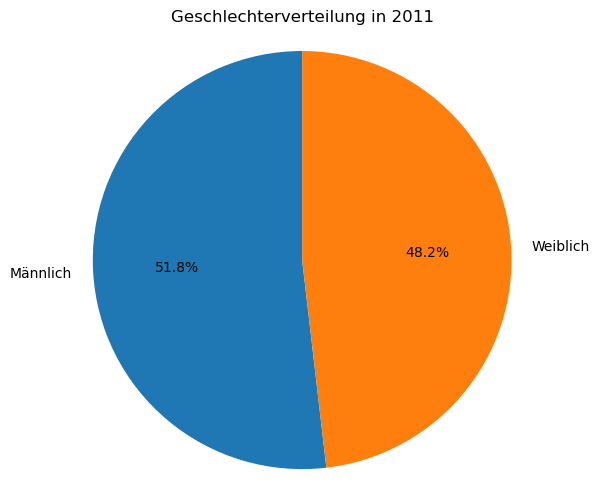

In [277]:
# Plot gender distribution
plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=['Männlich', 'Weiblich'], autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Geschlechterverteilung in 2011')
plt.show()

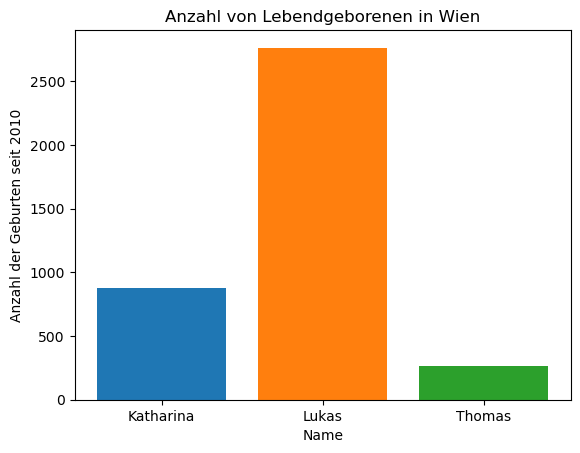

In [307]:
query = {
    "query": {
        "bool": {
            "must": [
                {"match": {"C-WOHNBEZIRK-0": 900}}
            ],
            "should": [
                {"match": {"F-VORNAME": "Katharina"}},
                {"match": {"F-VORNAME": "Lukas"}},
                {"match": {"F-VORNAME": "Thomas"}}
            ],
            "minimum_should_match": 1
        }
    }
}

source_fields = [
    "C-WOHNBEZIRK-0",
    "F-VORNAME",
    "F-ANZAHL_LGEB",
]

df2 = es_to_dataframe(es, index_name, query, source_fields)

location = 900

name = "Katharina"
filtered_data_katharina = df2[(df2["F-VORNAME"] == name) & (df2["C-WOHNBEZIRK-0"] == location)]
katharina_count = filtered_data_katharina["F-ANZAHL_LGEB"].sum()

name = "Lukas"
filtered_data_lukas = df2[(df2["F-VORNAME"] == name) & (df2["C-WOHNBEZIRK-0"] == location)]
lukas_count = filtered_data_lukas["F-ANZAHL_LGEB"].sum()

name = "Thomas"
filtered_data_thomas = df2[(df2["F-VORNAME"] == name) & (df2["C-WOHNBEZIRK-0"] == location)]
thomas_count = filtered_data_thomas["F-ANZAHL_LGEB"].sum()

# Create a bar plot
plt.bar(["Katharina"], [katharina_count])
plt.bar(["Lukas"], [lukas_count])
plt.bar(["Thomas"], [thomas_count])
plt.xlabel("Name")
plt.ylabel("Anzahl der Geburten seit 2010")
plt.title(f"Anzahl von Lebendgeborenen in Wien")
plt.show()

In [305]:
query = {
    "query": {
        "bool": {
            "must": [
                {"match": {"C-GESCHLECHT-0": 2}}
            ]
        }
    }
}

source_fields = [
    "C-WOHNBEZIRK-0",
    "F-VORNAME",
    "F-ANZAHL_LGEB",
]

df3 = es_to_dataframe(es, index_name, query, source_fields)

In [306]:
top_names = df3.groupby('F-VORNAME')['F-ANZAHL_LGEB'].sum()
sorted_names = top_names.sort_values(ascending=False)
sorted_names

F-VORNAME
Anna           24666
Sophie         16134
Marie          14621
Emilia         12818
Elena          11195
               ...  
Luiza-Maria        1
Luja               1
Luna-Mae           1
Lykka              1
Živana             1
Name: F-ANZAHL_LGEB, Length: 8244, dtype: int64

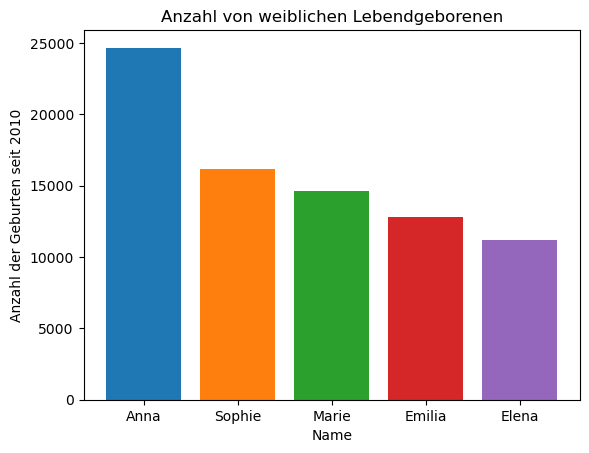

In [312]:
name = "Anna"
filtered_data_anna = df3[(df3["F-VORNAME"] == name)]
anna_count = filtered_data_anna["F-ANZAHL_LGEB"].sum()

name = "Sophie"
filtered_data_sophie = df3[(df3["F-VORNAME"] == name)]
sophie_count = filtered_data_sophie["F-ANZAHL_LGEB"].sum()

name = "Marie"
filtered_data_marie = df3[(df3["F-VORNAME"] == name)]
marie_count = filtered_data_marie["F-ANZAHL_LGEB"].sum()

name = "Emilia"
filtered_data_emilia = df3[(df3["F-VORNAME"] == name)]
emilia_count = filtered_data_emilia["F-ANZAHL_LGEB"].sum()

name = "Elena"
filtered_data_elena = df3[(df3["F-VORNAME"] == name)]
elena_count = filtered_data_elena["F-ANZAHL_LGEB"].sum()

# Create a bar plot
plt.bar(["Anna"], [anna_count])
plt.bar(["Sophie"], [sophie_count])
plt.bar(["Marie"], [marie_count])
plt.bar(["Emilia"], [emilia_count])
plt.bar(["Elena"], [elena_count])
plt.xlabel("Name")
plt.ylabel("Anzahl der Geburten seit 2010")
plt.title(f"Anzahl von weiblichen Lebendgeborenen")
plt.show()

In [309]:
query = {
    "query": {
        "bool": {
            "must": [
                {"match": {"C-GESCHLECHT-0": 1}}
            ]
        }
    }
}

source_fields = [
    "C-WOHNBEZIRK-0",
    "F-VORNAME",
    "F-ANZAHL_LGEB",
]

df4 = es_to_dataframe(es, index_name, query, source_fields)

In [310]:
top_names = df4.groupby('F-VORNAME')['F-ANZAHL_LGEB'].sum()
sorted_names = top_names.sort_values(ascending=False)
sorted_names

F-VORNAME
Lukas         17768
David         10785
Elias         10758
Jakob         10585
Maximilian    10206
              ...  
Si                1
Evian             1
Kiron             1
Shpreson          1
Sarjo             1
Name: F-ANZAHL_LGEB, Length: 7680, dtype: int64

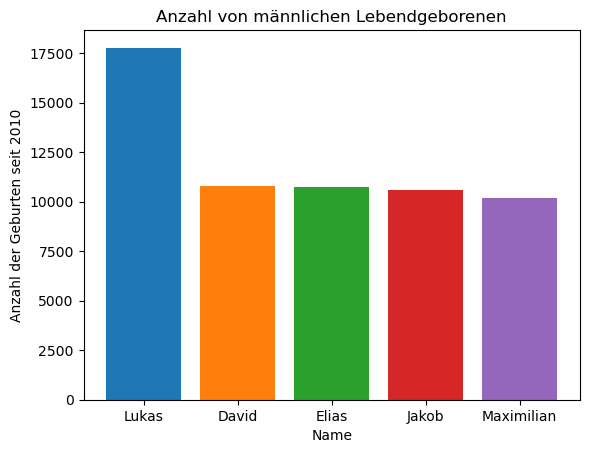

In [314]:
name = "Lukas"
filtered_data_lukas = df4[(df4["F-VORNAME"] == name)]
lukas_count = filtered_data_lukas["F-ANZAHL_LGEB"].sum()

name = "David"
filtered_data_david = df4[(df4["F-VORNAME"] == name)]
david_count = filtered_data_david["F-ANZAHL_LGEB"].sum()

name = "Elias"
filtered_data_elias = df4[(df4["F-VORNAME"] == name)]
elias_count = filtered_data_elias["F-ANZAHL_LGEB"].sum()

name = "Jakob"
filtered_data_jakob = df4[(df4["F-VORNAME"] == name)]
jakob_count = filtered_data_jakob["F-ANZAHL_LGEB"].sum()

name = "Maximilian"
filtered_data_maximilian = df4[(df4["F-VORNAME"] == name)]
maximilian_count = filtered_data_maximilian["F-ANZAHL_LGEB"].sum()

# Create a bar plot
plt.bar(["Lukas"], [lukas_count])
plt.bar(["David"], [david_count])
plt.bar(["Elias"], [elias_count])
plt.bar(["Jakob"], [jakob_count])
plt.bar(["Maximilian"], [maximilian_count])
plt.xlabel("Name")
plt.ylabel("Anzahl der Geburten seit 2010")
plt.title(f"Anzahl von männlichen Lebendgeborenen")
plt.show()

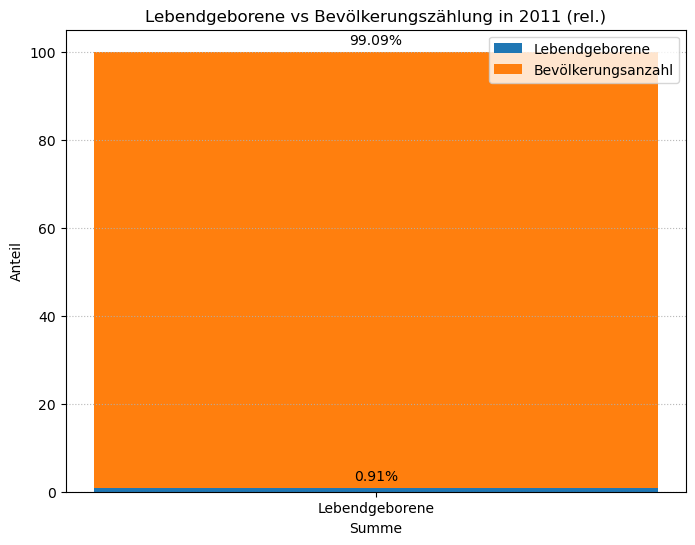

In [367]:
query = {
    "query": {
        "bool": {
            "must": [
                {"match": {"C-JAHR-0": 2011}}
            ]
        }
    }
}

source_fields = [
    "C-JAHR-0",
    "F-VORNAME",
    "F-ANZAHL_LGEB",
]

df5 = es_to_dataframe(es, index_name, query, source_fields)


name = "A/L"
AL_count = df5["F-ANZAHL_LGEB"].sum()

query = {
    "query": {
        "bool": {
            "must": [
                {"match": {"C-H88-0": "2011"}}
            ]
        }
    }
}

source_fields = [
    "C-H88-0",
    "F-ISIS-1",
    "C-GRGEM",
]

df6 = es_to_dataframe(es, index_name, query, source_fields)

# Ensure C-WOHNBEZIRK-0 has one characters by padding with zeros
population_2011 = df6.loc[df6['C-GRGEM'].astype(str).str.len() == 1]
population_2011_summary = population_2011.sum()

names = ["Lebendgeborene"]
counts = [AL_count]
total_population = population_2011_summary['F-ISIS-1']

# Calculate percentage
name_percentage = (np.array(counts) / total_population) * 100
population_percentage = 100 - name_percentage

fig, ax = plt.subplots(figsize=(8, 6))

# Create a stacked bar chart
bar_width = 0.4
x = np.arange(len(names))
bars1 = ax.bar(x, name_percentage, bar_width, label="Lebendgeborene")
bars2 = ax.bar(x, population_percentage, bar_width, bottom=name_percentage, label="Bevölkerungsanzahl")

# Add labels, title and custom x-axis tick labels
ax.set_xlabel("Summe")
ax.set_ylabel("Anteil")
ax.set_title("Lebendgeborene vs Bevölkerungszählung in 2011 (rel.)")
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend()

# Annotate the bars with their values
for bar, pct in zip(bars1, name_percentage):
    height = bar.get_height()
    ax.annotate('{:.2f}%'.format(pct),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

for bar, pct in zip(bars2, population_percentage):
    height = bar.get_height()
    ax.annotate('{:.2f}%'.format(pct),
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
    
plt.grid(axis='y', linestyle=':', alpha=0.9)

plt.show()


In [350]:
df5

,C-JAHR-0,F-VORNAME,F-ANZAHL_LGEB
0,2011,Adele,1
1,2011,Ajla,1
2,2011,Alena,1
3,2011,Alexandra,3
4,2011,Alina,4
...,...,...,...
13899,2011,Felix,5
13900,2011,Filopatir,1
13901,2011,Finn,1
13902,2011,Florian,5


### Index "idx1" löschen

In [210]:
es.options(ignore_status=[400,404]).indices.delete(index='idx2')

ObjectApiResponse({'acknowledged': True})